Click recording enabled. Click on a star!
Clicked at: X=903, Y=1161
Last click undone.
Click recording enabled. Click on a star!
Clicked at: X=1036, Y=1016
Estimating FWHM at X=1036, Y=1016...
Estimated centroid X=15, Y=15


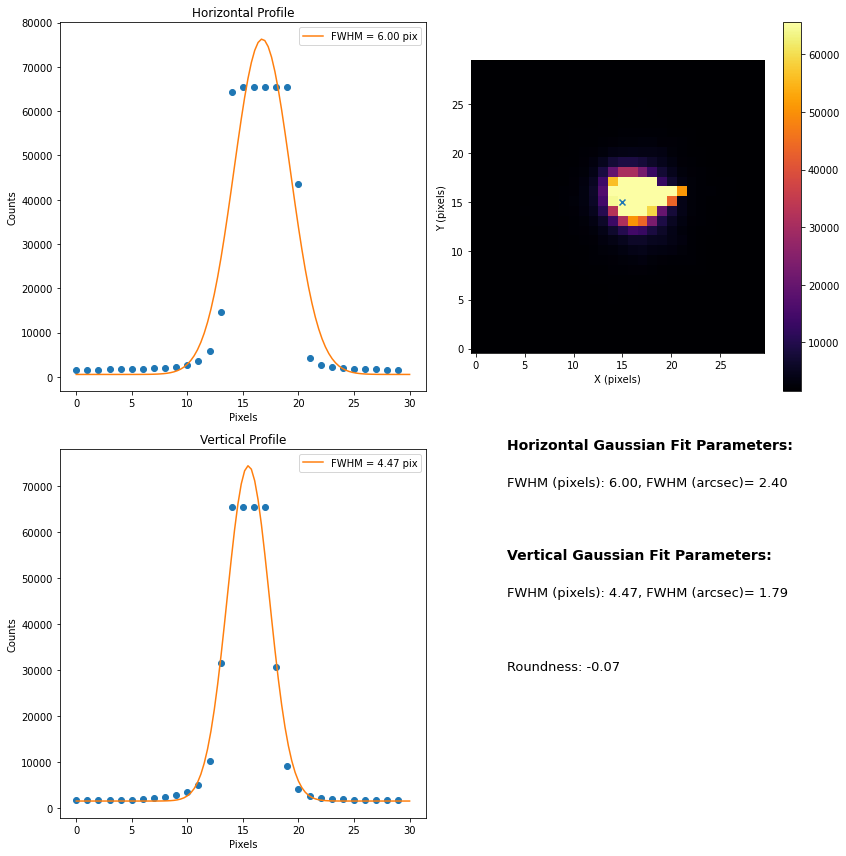

Last click undone.
Click recording enabled. Click on a star!
Clicked at: X=1753, Y=1338
Estimating FWHM at X=1753, Y=1338...
Estimated centroid X=14, Y=16


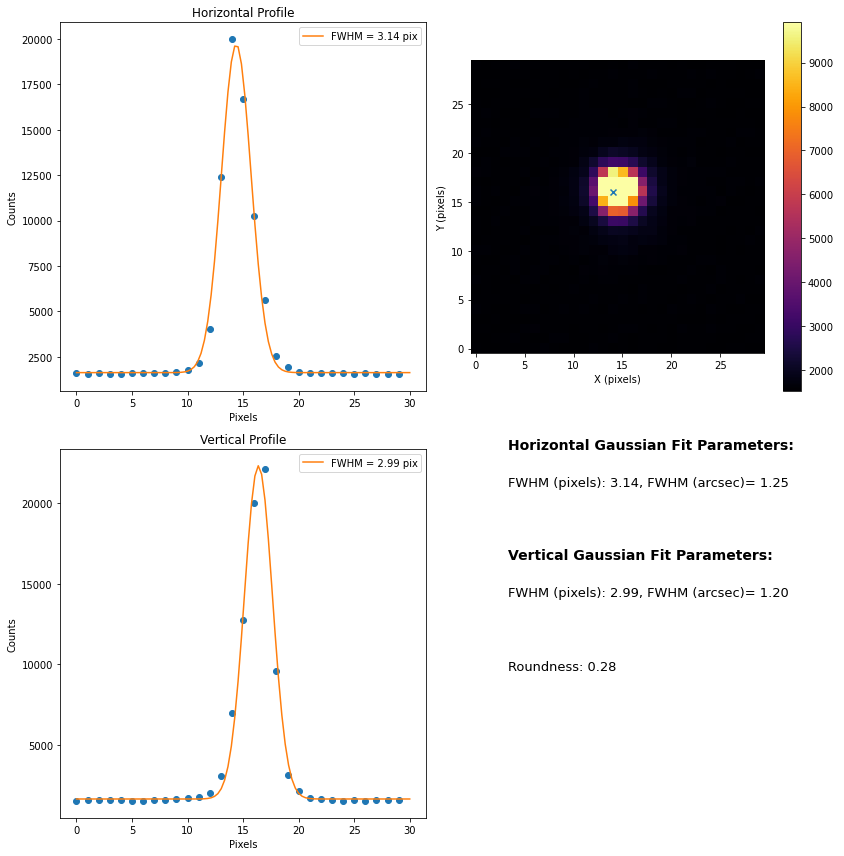

Click recording enabled. Click on a star!
Clicked at: X=2425, Y=3614
Estimating FWHM at X=2425, Y=3614...
Estimated centroid X=14, Y=5


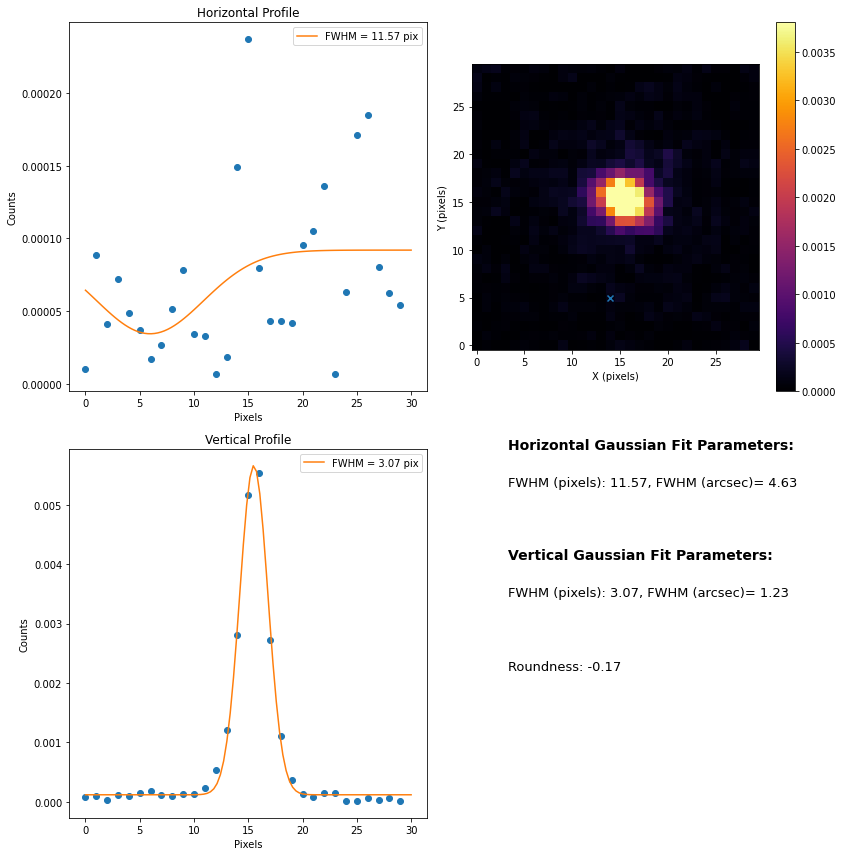

SystemExit: 0

/home/ashish/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QWidget, QPushButton, QSlider, QLabel, QHBoxLayout, QLineEdit, QFileDialog
from PyQt5.QtCore import Qt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.backends.backend_qt5agg import NavigationToolbar2QT as NavigationToolbar
from matplotlib.figure import Figure
from astropy.io import fits
from scipy.optimize import curve_fit
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

class FITSClickApp(QMainWindow):
    def __init__(self):
        super().__init__()

        self.fits_path = None  # Initialize fits_path to None
        self.click_enabled = False  # Disable click recording initially
        self.clicked_points = []  # Store clicked points for undo
        self.image_data = None  # Initialize image data as None
        self.initUI()

    def initUI(self):
        self.setWindowTitle("Interactive FITS Image Click Tool")
        self.setGeometry(100, 100, 900, 700)

        # Create a central widget
        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)

        # Create main layout
        main_layout = QVBoxLayout()
        self.central_widget.setLayout(main_layout)

        # Top section with the button and line edit
        top_layout = QHBoxLayout()
        
        # Open File Button
        self.open_btn = QPushButton("Open File ")
        self.open_btn.clicked.connect(self.open_file)
        top_layout.addWidget(self.open_btn)

        # Path display QLineEdit
        self.path_display = QLineEdit()
        self.path_display.setReadOnly(True)  # Make it read-only, user can't type here
        top_layout.addWidget(self.path_display)

        # Display Image Button
        self.display_btn = QPushButton("Display Image")
        self.display_btn.clicked.connect(self.display_image)
        top_layout.addWidget(self.display_btn)
        
        main_layout.addLayout(top_layout)
        
        # Top section with the button and line edit
        ps_layout = QHBoxLayout()
        
        # Platescale
        self.platescale_label = QLabel("Plate Scale")
        ps_layout.addWidget(self.platescale_label)
        
        self.platescale_edit = QLineEdit()
        self.platescale_edit.setPlaceholderText("Default: 0.2")
        self.platescale = 0.2 # setting the default value
        self.platescale_edit.setFixedWidth(200)
        self.platescale_edit.textChanged.connect(self.update_platescale)
        ps_layout.addWidget(self.platescale_edit)
        ps_layout.addStretch()
        
        main_layout.addLayout(ps_layout)

        # Create Matplotlib Figure and Canvas
        self.figure = Figure()
        self.canvas = FigureCanvas(self.figure)
        main_layout.addWidget(self.canvas)

        # Add Matplotlib Navigation Toolbar (for Zoom & Pan)
        self.toolbar = NavigationToolbar(self.canvas, self)
        main_layout.addWidget(self.toolbar)

        # Connect click event
        self.canvas.mpl_connect("button_press_event", self.on_click)

        # Control panel layout
        control_layout = QHBoxLayout()

        # Select Star Button
        self.select_btn = QPushButton("Select Star")
        self.select_btn.clicked.connect(self.enable_click)
        control_layout.addWidget(self.select_btn)

        # Undo Button
        self.undo_btn = QPushButton("Undo")
        self.undo_btn.clicked.connect(self.undo_click)
        control_layout.addWidget(self.undo_btn)

        # Estimate FWHM Button
        self.fwhm_btn = QPushButton("Estimate FWHM")
        self.fwhm_btn.clicked.connect(self.estimate_fwhm)
        control_layout.addWidget(self.fwhm_btn)

        # Contrast Slider
        self.slider_label = QLabel("Contrast:")
        control_layout.addWidget(self.slider_label)

        self.contrast_slider = QSlider(Qt.Horizontal)
        self.contrast_slider.setMinimum(1)
        self.contrast_slider.setMaximum(100)
        self.contrast_slider.setValue(50)  # Default position
        self.contrast_slider.valueChanged.connect(self.adjust_contrast)
        control_layout.addWidget(self.contrast_slider)

        # Exit Button
        self.exit_btn = QPushButton("Exit")
        self.exit_btn.clicked.connect(self.close)
        control_layout.addWidget(self.exit_btn)

        main_layout.addLayout(control_layout)
        self.show()

    def open_file(self):
        """Open a file dialog to select a FITS file and display its path."""
        file_name, _ = QFileDialog.getOpenFileName(self, "Open FITS File", "", 
                                                   "FITS Files (*.fits *.fit *.fts);;All Files (*)")
        if file_name:
            self.fits_path = file_name
            self.path_display.setText(file_name)  # Display the file path

    def display_image(self):
        """Display the selected FITS image."""
        if not self.fits_path:
            print("No file selected.")
            return

        # Create a new axis for the image (clearing the old one)
        self.figure.clf()  # Clear the entire figure
        self.ax = self.figure.add_subplot(111)  # Create a new axis
        self.canvas.draw()

        with fits.open(self.fits_path) as hdul:
            self.image_data = hdul[0].data  # Load the first extension image data

        # Set default contrast levels
        self.vmin = np.percentile(self.image_data, 5)
        self.vmax = np.percentile(self.image_data, 95)

        # Display the image on the newly created axis
        self.img = self.ax.imshow(self.image_data, cmap='gray', origin='lower',
                                  vmin=self.vmin, vmax=self.vmax)
        self.ax.set_title(f"FITS Image: {self.fits_path.split('/')[-1]}")
        self.canvas.draw()

    def enable_click(self):
        """Enable click recording when the button is pressed."""
        self.click_enabled = True
        print("Click recording enabled. Click on a star!")

    def on_click(self, event):
        """Record clicks only when enabled and store them."""
        if self.click_enabled and event.xdata is not None and event.ydata is not None:
            x, y = int(event.xdata), int(event.ydata)
            self.clicked_points.append((x, y))
            print(f"Clicked at: X={x}, Y={y}")

            # Mark the clicked point
            point, = self.ax.plot(x, y, 'ro', markersize=5)
            self.canvas.draw()

            # Store the point for potential undo
            self.click_enabled = False  # Disable click recording after one click

    def undo_click(self):
        """Remove the last clicked point."""
        if self.clicked_points:
            self.clicked_points.pop()  # Remove last point
            self.canvas.draw()
            print("Last click undone.")
            

    def update_platescale(self):
        """Update the platescale value whenever the user enters a value."""
        try:
            self.platescale = float(self.platescale_edit.text())
        except ValueError:
            self.platescale = 0.2  # Reset if the input is invalid            
            

    def estimate_fwhm(self):
        """Estimate the Full Width at Half Maximum (FWHM) of the selected star."""
        if not self.clicked_points:
            print("No star selected. Click on a star first.")
            return
        
        x, y = self.clicked_points[-1]  # Get last clicked star
        print(f"Estimating FWHM at X={x}, Y={y}...")
        
        def gaussian(X, amp, mean, sigma, offset):
            return amp * np.exp(-0.5 * ((X - mean) / sigma) ** 2) + offset

        # Extract a small region around the star
        size = 15  # Size of the box around the star
        x_min, x_max = max(0, x - size), min(self.image_data.shape[1], x + size)
        y_min, y_max = max(0, y - size), min(self.image_data.shape[0], y + size)
        star = self.image_data[y_min:y_max, x_min:x_max]
        
        # Detecting the star inside the window (this is to avoid centroid variations based on window size).
        mean, median, std = sigma_clipped_stats(star, sigma=3.0) # estimating mean background and std dev
        daofind = DAOStarFinder(fwhm=3.7, threshold=3.*std)
        sources = daofind(star - median)
        
        if len(sources)!= 0:
            xcentroid = int(sources['xcentroid'][0])
            ycentroid = int(sources['ycentroid'][0])
            roundness = sources['roundness1'][0]
            print(f"Estimated centroid X={xcentroid}, Y={ycentroid}")

            # Extract horizontal and vertical pixel values
            horizontal_pixels = star[ycentroid, :]  # Row containing the element
            vertical_pixels = star[:, xcentroid]  # Column containing the element
            X = np.arange(0, len(horizontal_pixels))
            Y = np.arange(0, len(vertical_pixels))
            
            
#             # Updating the extracted star based on the centroids estimated
#             size = 15  # Size of the box around the star
#             x_min, x_max = max(0, xcentroid - size), min(self.image_data.shape[1], xcentroid + size)
#             y_min, y_max = max(0, ycentroid - size), min(self.image_data.shape[0], ycentroid + size)
#             star_plot = self.image_data[y_min:y_max, x_min:x_max]
            
            

            Xfit = np.linspace(0, len(horizontal_pixels), 100)
            Yfit = np.linspace(0, len(vertical_pixels), 100)

            # Initial guesses for Gaussian fitting
            initial_guess_h = [np.max(horizontal_pixels), ycentroid, 5, np.min(horizontal_pixels)]
            initial_guess_v = [np.max(vertical_pixels), xcentroid, 5, np.min(vertical_pixels)]  

            try:
                # Fit Gaussian to horizontal pixels
                popt_h, pcov_h = curve_fit(gaussian, X, horizontal_pixels, p0=initial_guess_h)

                # Fit Gaussian to vertical pixels
                popt_v, pcov_v = curve_fit(gaussian, Y, vertical_pixels, p0=initial_guess_v)

                # Extract fitted parameters
                amp_h, mean_h, sigma_h, offset_h = popt_h
                amp_v, mean_v, sigma_v, offset_v = popt_v

                fwhm_h, fwhm_ha = 2.35482*sigma_h, self.platescale*2.35482*sigma_h
                fwhm_v, fwhm_va = 2.35482*sigma_v, self.platescale*2.35482*sigma_v

                # Plot data and fits
                fig, ax = plt.subplots(2, 2, figsize=(12, 12))

                # Plot horizontal pixels
                ax[0][0].plot(X, horizontal_pixels, 'o')
                ax[0][0].plot(Xfit, gaussian(Xfit, *popt_h), '-', label=f'FWHM = {2.35482*sigma_h:.2f} pix')
                ax[0][0].set_xlabel('Pixels')
                ax[0][0].set_ylabel('Counts')
                ax[0][0].legend()
                ax[0][0].set_title('Horizontal Profile')

                plt.subplots_adjust(hspace=0.3)

                # Plot vertical pixels
                ax[1][0].plot(Y, vertical_pixels, 'o')
                ax[1][0].plot(Yfit, gaussian(Yfit, *popt_v), '-', label=f'FWHM = {2.35482*sigma_v:.2f} pix')
                ax[1][0].set_xlabel('Pixels')
                ax[1][0].set_ylabel('Counts')
                ax[1][0].legend()
                ax[1][0].set_title('Vertical Profile')
                
                
                Starvmin = np.percentile(star, 1)
                Starvmax = np.percentile(star, 99)
                img = ax[0][1].imshow(star, cmap='inferno', origin='lower', vmin=Starvmin, vmax=Starvmax)
                ax[0][1].scatter(xcentroid, ycentroid, marker='x')
                ax[0][1].set_xlabel('X (pixels)')
                ax[0][1].set_ylabel('Y (pixels)')

                ax[1][1].axis('off')

                # Print the Gaussian fit parameters
                ax[1][1].text(0.1,1, "Horizontal Gaussian Fit Parameters:", weight='bold', fontsize=14)
                ax[1][1].text(0.1,0.9,f"FWHM (pixels): {2.35482*sigma_h:.2f}, FWHM (arcsec)= {self.platescale*2.35482*sigma_h:.2f} ", fontsize=13)
                ax[1][1].text(0.1,0.7,"\nVertical Gaussian Fit Parameters:", weight='bold', fontsize=14)
                ax[1][1].text(0.1,0.6,f"FWHM (pixels): {2.35482*sigma_v:.2f}, FWHM (arcsec)= {self.platescale*2.35482*sigma_v:.2f}", fontsize=13)
                ax[1][1].text(0.1,0.4,f"Roundness: {roundness:.2f}", fontsize=13)

                # Add a colorbar
                plt.colorbar(img)
                
                plt.tight_layout()
                plt.show()

            except RuntimeError as e:
                fwhm_h, fwhm_ha = 0, 0
                fwhm_v, fwhm_va = 0, 0
        
        
        else:
            print("I did not find a star")
        

    def adjust_contrast(self):
        """Adjust contrast dynamically based on slider value."""
        scale = self.contrast_slider.value() / 50  # Normalize to [0.5, 2]
        new_vmin = np.percentile(self.image_data, 5) * scale
        new_vmax = np.percentile(self.image_data, 95) * scale

        self.img.set_clim(new_vmin, new_vmax)
        self.canvas.draw()

if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = FITSClickApp()  # Removed the path argument as it's no longer needed
    sys.exit(app.exec_())